In [1]:
cd ../src

c:\Users\fredl\Documents\Cours\M1 Androide\S2\ML\Projet\src


C:\Users\fredl\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from activation_func import *
from loss import *
from module import *
from optimizers import *
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def collect_states(env, n_samples=1000):
    states = []
    obs, _ = env.reset()
    for _ in range(n_samples):
        states.append(obs)
        action = env.action_space.sample()
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            obs, _ = env.reset()
    return np.array(states)

def normalize(X):
    mean = X.mean(axis=0)
    std = X.std(axis=0) + 1e-8
    return (X - mean) / std, mean, std

def train_autoencoder(autoencoder, X, epochs=100, batch_size=64, lr=1e-2):
    losses = []
    for epoch in range(epochs):
        perm = np.random.permutation(len(X))
        X_shuffled = X[perm]

        epoch_loss = 0
        for i in range(0, len(X), batch_size):
            x_batch = X_shuffled[i:i + batch_size]
            autoencoder.zero_grad()
            x_hat = autoencoder.forward(x_batch)
            loss = autoencoder.backward(x_hat, x_batch)
            autoencoder.step(lr)
            epoch_loss += loss

        losses.append(epoch_loss / (len(X) / batch_size))
        print(f"Epoch {epoch+1}, Loss: {losses[-1]:.5f}")
    return losses

def visualize_reconstruction(autoencoder, X, mean, std):
    X_denorm = X * std + mean
    X_hat = autoencoder.reconstruct(X)
    X_hat_denorm = X_hat * std + mean
    for i in range(5):
        print(f"Original: {X_denorm[i]}, Reconstructed: {X_hat_denorm[i]}")

def visualize_latent_space(autoencoder, X, y):
    Z = autoencoder.encode(X)
    if Z.shape[1] == 2:
        plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap='viridis')
        plt.title("Latent space (2D)")
        plt.colorbar()
        plt.show()

env = gym.make("CartPole-v1")
states = collect_states(env, n_samples=2000)
states, mean, std = normalize(states)

encoder = Sequential(
    Linear(4, 64),
    TanH(),
    Linear(64, 10),
    TanH()
)
decoder = Sequential(
    Linear(10, 64),
    TanH(),
    Linear(64, 4),
    Sigmoid()
)
loss_fn = BCELoss()
autoencoder = AutoEncoder(encoder, decoder, loss_fn)
losses = train_autoencoder(autoencoder, states, epochs=100, batch_size=64, lr=1e-2)

print("\nReconstructions :")
visualize_reconstruction(autoencoder, states[:5], mean, std)

print("\nLatent Space (colored by angle bucket)")
y_labels = (states[:, 2] > 0).astype(int)  # Classif binaire selon l'angle
visualize_latent_space(autoencoder, states, y_labels)

c:\Users\fredl\Documents\Cours\M1 Androide\S2\ML\Projet\src\activation_func.py:23: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-X))


Epoch 1, Loss: 2.94927
Epoch 2, Loss: 2.83732
Epoch 3, Loss: 2.82321
Epoch 4, Loss: 2.81329
Epoch 5, Loss: 2.83284
Epoch 6, Loss: 2.82973
Epoch 7, Loss: 2.83191
Epoch 8, Loss: 2.85050
Epoch 9, Loss: 2.78935
Epoch 10, Loss: 2.83640
Epoch 11, Loss: 2.81594
Epoch 12, Loss: 2.82571
Epoch 13, Loss: 2.83104
Epoch 14, Loss: 2.84775
Epoch 15, Loss: 2.86087
Epoch 16, Loss: 2.84322
Epoch 17, Loss: 2.83404
Epoch 18, Loss: 2.80418
Epoch 19, Loss: 2.84925
Epoch 20, Loss: 2.83817
Epoch 21, Loss: 2.82209
Epoch 22, Loss: 2.85198
Epoch 23, Loss: 2.87956
Epoch 24, Loss: 2.85842
Epoch 25, Loss: 2.84951
Epoch 26, Loss: 2.85135
Epoch 27, Loss: 2.82914
Epoch 28, Loss: 2.83615
Epoch 29, Loss: 2.83712
Epoch 30, Loss: 2.84247
Epoch 31, Loss: 2.86690
Epoch 32, Loss: 2.85665
Epoch 33, Loss: 2.82416
Epoch 34, Loss: 2.83016
Epoch 35, Loss: 2.86019
Epoch 36, Loss: 2.81773
Epoch 37, Loss: 2.85601
Epoch 38, Loss: 2.80914
Epoch 39, Loss: 2.87418
Epoch 40, Loss: 2.82985
Epoch 41, Loss: 2.84674
Epoch 42, Loss: 2.85721
E

In [ ]:
Q_net = Sequential(
    Linear(10, 64),
    TanH(),
    Linear(64, 2)  # 2 actions dans CartPole
)
q_loss = MSELoss()

# Hyperparamètres Q-learning
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
lr = 1e-4
episodes = 20000
max_steps = 20000

env = gym.make("CartPole-v1")
rewards = []

for ep in range(episodes):
    obs, _ = env.reset()
    obs = (obs - mean) / std  # Normalise comme à l’entraînement de l’autoencodeur
    total_reward = 0

    for step in range(max_steps):
        latent = encoder.forward(obs.reshape(1, -1))  # (1, dim_latent)
        q_values = Q_net.forward(latent)  # (1, 2)

        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_values)

        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_obs = (next_obs - mean) / std
        next_latent = encoder.forward(next_obs.reshape(1, -1))
        next_q_values = Q_net.forward(next_latent)

        target = q_values.copy()
        if done:
            target[0, action] = reward
        else:
            target[0, action] = reward + gamma * np.max(next_q_values)

        # Entraînement
        Q_net.zero_grad()
        pred = Q_net.forward(latent)
        loss = q_loss.forward(pred, target)
        grad = q_loss.backward(pred, target)
        Q_net.backward(grad)
        Q_net.update_parameters(lr)

        obs = next_obs
        total_reward += reward
        if done:
            break

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)
    if (ep + 1) % 100 == 0:
        print(f"Episode {ep+1}, Avg Reward: {np.mean(rewards[-100:]):.2f}, Epsilon: {epsilon:.3f}")

env.close()


Episode 1, Reward: 23.0, Epsilon: 0.995
Episode 2, Reward: 17.0, Epsilon: 0.990
Episode 3, Reward: 18.0, Epsilon: 0.985
Episode 4, Reward: 31.0, Epsilon: 0.980
Episode 5, Reward: 17.0, Epsilon: 0.975
Episode 6, Reward: 15.0, Epsilon: 0.970
Episode 7, Reward: 12.0, Epsilon: 0.966
Episode 8, Reward: 11.0, Epsilon: 0.961
Episode 9, Reward: 28.0, Epsilon: 0.956
Episode 10, Reward: 65.0, Epsilon: 0.951
Episode 11, Reward: 9.0, Epsilon: 0.946
Episode 12, Reward: 37.0, Epsilon: 0.942
Episode 13, Reward: 23.0, Epsilon: 0.937
Episode 14, Reward: 17.0, Epsilon: 0.932
Episode 15, Reward: 15.0, Epsilon: 0.928
Episode 16, Reward: 15.0, Epsilon: 0.923
Episode 17, Reward: 17.0, Epsilon: 0.918
Episode 18, Reward: 12.0, Epsilon: 0.914
Episode 19, Reward: 37.0, Epsilon: 0.909
Episode 20, Reward: 24.0, Epsilon: 0.905
Episode 21, Reward: 30.0, Epsilon: 0.900
Episode 22, Reward: 15.0, Epsilon: 0.896
Episode 23, Reward: 54.0, Epsilon: 0.891
Episode 24, Reward: 25.0, Epsilon: 0.887
Episode 25, Reward: 12.0, 

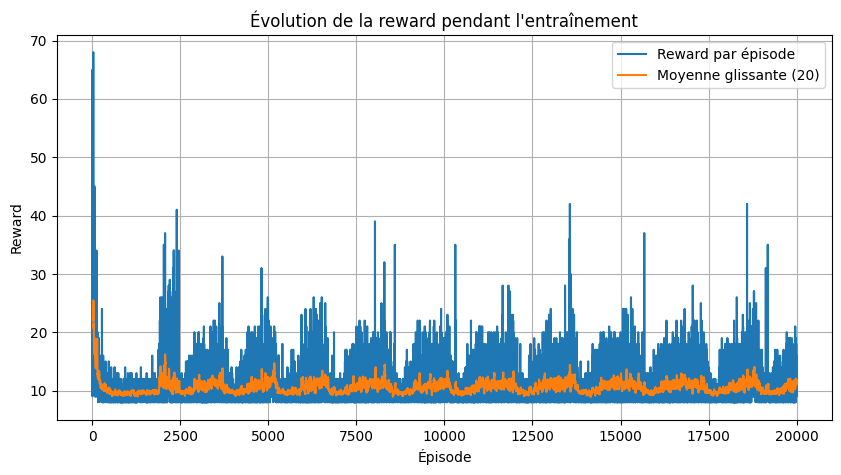

In [10]:
def plot_rewards(rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, label="Reward par épisode")
    window = 20
    if len(rewards) >= window:
        smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(range(window - 1, len(rewards)), smooth, label=f"Moyenne glissante ({window})")
    plt.xlabel("Épisode")
    plt.ylabel("Reward")
    plt.title("Évolution de la reward pendant l'entraînement")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards(rewards)